In [1]:
import torch
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append('/home/ql2221/Projects/thermalizer/thermalizer/kolmogorov')
import performance
sys.path.append('/home/ql2221/Projects/thermalizer/thermalizer/models')
import misc
sys.path.append('/home/ql2221/Projects/thermalizer/thermalizer/systems')
import training_systems

In [2]:
#get the emulator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
file_string = "/scratch/ql2221/thermalizer_data/wandb_data/wandb/run-20250709_231256-pime4jqo/files/checkpoint_last.p"
with open(file_string, 'rb') as f:
    checkpoint = pickle.load(f)

# Extract the configuration (this might include hyperparameters, model architecture details, etc.)
config = checkpoint['config']

In [3]:
emu=misc.load_model(file_string).to(device)

In [4]:
#load data
import pickle

# Load data from a .pkl file
with open("/scratch/cp3759/thermalizer_data/kolmogorov/reynolds10k/test40.p", "rb") as f:
    loaded_data = pickle.load(f)

sim_stack_loaded = loaded_data["data"]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = sim_stack_loaded[0,:,:,:]/4.44
x = x.unsqueeze(0).to(device)
print(x.shape)

torch.Size([1, 25000, 64, 64])


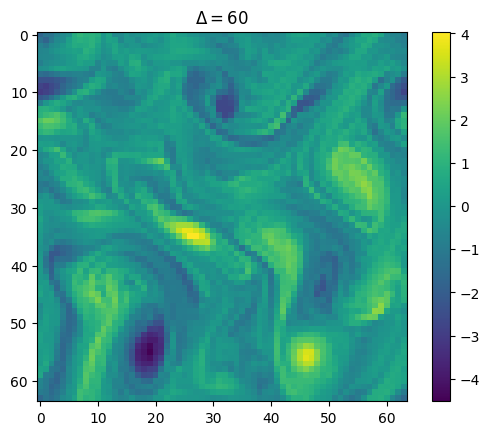

In [6]:
#peak at data
tensor = x[:,0]

# Remove the singleton dimension
tensor = tensor.squeeze(0)  # Now shape is (64, 64)

# Convert to NumPy
tensor_np = tensor.detach().cpu().numpy()

# Plot using cmocean colormap
plt.imshow(tensor_np)  # You can choose different cmocean colormaps
plt.colorbar()
plt.title(r'$\Delta = 60$')
# plt.savefig("noised.png")
plt.show()

In [10]:
ics = x[:,0:1]
emu_rollout, ens, _=performance.run_emu(ics, emu, n_steps=10000, silent=False)

100%|██████████| 9999/9999 [01:05<00:00, 152.46it/s]


In [11]:
from matplotlib import animation
def make_movie(state_vector, save_path="emulator_movie.mp4", fps=30, vmin=None, vmax=None, stride=10):
    """
    Create a movie from a 4D tensor of shape (batch, time, height, width), using only every `stride`-th frame.
    
    Parameters:
    - state_vector: torch.Tensor of shape (B, T, H, W)
    - save_path: output video file path
    - fps: frames per second for the movie
    - vmin, vmax: color scale
    - stride: only include every `stride`th frame in the video
    """
    B, T, H, W = state_vector.shape
    data = state_vector[0].cpu().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(data[0], cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title("Timestep 0")
    fig.colorbar(im, ax=ax)

    # Frame indices to use
    frame_indices = list(range(0, T, stride))

    def update(frame_idx):
        frame = frame_indices[frame_idx]
        im.set_data(data[frame])
        ax.set_title(f"Timestep {frame}")
        return im,

    ani = animation.FuncAnimation(fig, update, frames=len(frame_indices), blit=False, repeat=False)
    ani.save(save_path, fps=fps)
    plt.close(fig)
    print("movie saved")

In [12]:
make_movie(emu_rollout, save_path="rollout.mp4", fps=30)

movie saved


In [14]:
make_movie(x, save_path="ground_truth.mp4", fps=30)

movie saved
